In [ ]:
import pandas as pd
abe = pd.read_excel('Abemaciclib.xlsx', header=1)
dal = pd.read_excel('Dalpiciclib.xlsx', header=1)
pal = pd.read_excel('Palbociclib.xlsx', header=1)
rib = pd.read_excel('Ribociclib.xlsx', header=1)

In [ ]:
rib

,Target,Common name,Uniprot ID,ChEMBL ID,Target Class,Probability*,Known actives (3D/2D)
0,Cyclin-dependent kinase 6,CDK6,Q00534,CHEMBL2508,Kinase,0.999915,108 / 247
1,Cyclin-dependent kinase 4,CDK4,P11802,CHEMBL331,Kinase,0.999915,256 / 617
2,Cyclin-dependent kinase 1,CDK1,P06493,CHEMBL308,Kinase,0.775772,51 / 57
3,Cyclin-dependent kinase 2,CDK2,P24941,CHEMBL301,Kinase,0.405297,67 / 14
4,Serine/threonine-protein kinase Aurora-B,AURKB,Q96GD4,CHEMBL2185,Kinase,0.106543,36 / 43
...,...,...,...,...,...,...,...
98,TRAF2- and NCK-interacting kinase,TNIK,Q9UKE5,CHEMBL4527,Kinase,0.106543,6 / 0
99,Homeodomain-interacting protein kinase 2,HIPK2,Q9H2X6,CHEMBL4576,Kinase,0.106543,4 / 0
100,Homeodomain-interacting protein kinase 3,HIPK3,Q9H422,CHEMBL4577,Kinase,0.106543,4 / 0
101,Maternal embryonic leucine zipper kinase,MELK,Q14680,CHEMBL4578,Kinase,0.106543,40 / 0


In [ ]:
abe_genes = set(abe['Common name'])
dal_genes = set(dal['Common name'])
pal_genes = set(pal['Common name'])
rib_genes = set(rib['Common name'])

union_genes = abe_genes.union(dal_genes, pal_genes, rib_genes)

intersection_genes = abe_genes.intersection(dal_genes, pal_genes, rib_genes)

In [ ]:
print(len(abe_genes) + len(dal_genes) + len(pal_genes) + len(rib_genes))
print(len(union_genes))
print(len(intersection_genes))

360
225
7


In [ ]:
intersection_genes

{'CCNB1', 'CCND1', 'CCND2', 'CCND3', 'CDK1', 'CDK4', 'CDK6'}

In [ ]:
df_union_genes = pd.DataFrame(list(union_genes), columns=['Gene'])

df_union_genes.to_csv('union_genes.csv', index=False)

In [ ]:
import pandas as pd
combined_data = []

for df in [abe, dal, pal, rib]:
  combined_data.extend(df.to_dict('records'))

df_all_genes = pd.DataFrame(combined_data)

df_all_genes = df_all_genes.drop_duplicates(subset=['Common name'], keep='first')

df_all_genes = df_all_genes.drop('Target', axis=1)

df_all_genes.to_csv('all_genes.csv', index=False)


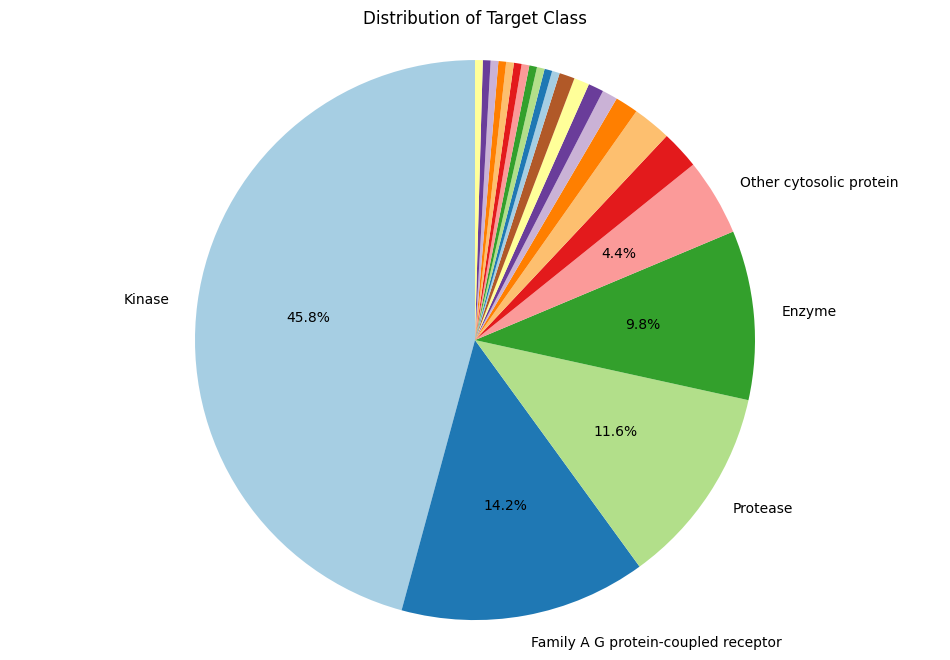

In [ ]:
import matplotlib.pyplot as plt

target_class_counts = df_all_genes['Target Class'].value_counts()

top = target_class_counts.nlargest(5)

plt.figure(figsize=(12, 8))
plt.pie(target_class_counts,
        labels=[label if label in top.index else '' for label in target_class_counts.index],
        autopct=lambda p: '{:.1f}%'.format(p) if p >= top.min()/target_class_counts.sum() * 100 else '',
        startangle=90,
        colors=plt.cm.Paired.colors)

plt.title('Distribution of Target Class')
plt.axis('equal') 
plt.savefig('target_class_distribution.png')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.savefig('target_class_distribution.png')


In [ ]:
import numpy as np
import pandas as pd
import pandas as pd

all_genes_df = pd.read_csv('all_genes.csv', sep=',')
ihc_df = pd.read_csv('normal_ihc_data.tsv', sep='\t')

all_genes_df['Common name'] = all_genes_df['Common name'].str.upper()
ihc_df['Gene name'] = ihc_df['Gene name'].str.upper()
ihc_df = ihc_df[ihc_df['Reliability'] != 'Uncertain']

ihc_filtered = ihc_df[ihc_df['Gene name'].isin(all_genes_df['Common name'])]

ihc_filtered = ihc_filtered.drop(columns=['IHC tissue name'])

level_priority = {'Not detected': 0, 'Low': 1, 'Medium': 2, 'High': 3}

ihc_filtered = ihc_filtered[ihc_filtered['Level'].isin(level_priority.keys())]

ihc_filtered['Level score'] = ihc_filtered['Level'].map(level_priority)

In [ ]:
# Define the list of relevant immune-related cell types
target_cell_types = [
    'lymphoid tissue',
    'hematopoietic cells',
    'germinal center cells',
    'non-germinal center cells',
    'hofbauer cells',
    'Langerhans',
    'langerhans cells',
    'lymphocytes',
    'mucosal lymphoid cells',
    'paneth cells',
    'medullary cells',
    'macrophages',
    'cells in red pulp',
    'cells in white pulp'
]

immune_ihc = ihc_filtered[ihc_filtered['Cell type'].isin(target_cell_types)]
nonimmune_ihc = ihc_filtered[~ihc_filtered['Cell type'].isin(target_cell_types)]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

immune_ihc['Group'] = 'Immune'
nonimmune_ihc['Group'] = 'Non-Immune'
combined_df = pd.concat([immune_ihc, nonimmune_ihc], ignore_index=True)

MIN_N = 5

results = []
excluded_genes = []

genes = combined_df['Gene name'].unique()

for gene in genes:
    group1 = combined_df[(combined_df['Gene name'] == gene) & (combined_df['Group'] == 'Immune')]['Level score']
    group2 = combined_df[(combined_df['Gene name'] == gene) & (combined_df['Group'] == 'Non-Immune')]['Level score']

    if len(group1) >= MIN_N and len(group2) >= MIN_N:
        stat, p = mannwhitneyu(group1, group2, alternative='two-sided')
        median1 = group1.median()
        median2 = group2.median()
        mean1 = group1.mean()
        mean2 = group2.mean()

        results.append({
            'Gene name': gene,
            'pval': p,
            'Immune_median': median1,
            'Non-immune_median': median2,
            'Immune_mean': mean1,
            'Non-immune_mean': mean2
        })
    else:
        excluded_genes.append(gene)
        continue

results_df = pd.DataFrame(results)

if not results_df.empty:
    results_df['adj_pval'] = multipletests(results_df['pval'], method='fdr_bh')[1]

    def determine_higher(row):
        if row['adj_pval'] >= 0.05:
            return 'NA'
        if row['Immune_median'] > row['Non-immune_median']:
            return 'Immune'
        elif row['Non-immune_median'] > row['Immune_median']:
            return 'Non-Immune'
        else:
            if row['Immune_mean'] > row['Non-immune_mean']:
                return 'Immune'
            elif row['Non-immune_mean'] > row['Immune_mean']:
                return 'Non-Immune'
            else:
                return 'NA'

    results_df['Higher In'] = results_df.apply(determine_higher, axis=1)

    significant_df = results_df[results_df['adj_pval'] < 0.05].copy()
    significant_genes = significant_df['Gene name'].tolist()
    print(f"✅ Found {len(significant_genes)} significant genes with FDR < 0.05.")
else:
    significant_df = pd.DataFrame()
    significant_genes = []
    print("⚠️ No valid genes passed the minimum sample size threshold.")

print(f"⚠️ Excluded {len(excluded_genes)} genes due to insufficient sample size in at least one group.")

results_df.to_csv("all_gene_stats.csv", index=False)
significant_df.to_csv("significant_gene_stats.csv", index=False)

os.makedirs("plots", exist_ok=True)

for _, row in significant_df.iterrows():
    gene = row['Gene name']
    pval = row['adj_pval']

    data = combined_df[(combined_df['Gene name'] == gene)].dropna(subset=['Level score'])

    plt.figure(figsize=(6, 4))
    ax = sns.violinplot(data=data, x='Group', y='Level score', inner='box', palette='Set2', hue='Group')

    plt.title(f'{gene}', fontsize=14, fontweight='bold')
    plt.xlabel('')
    plt.ylabel('Protein Expression (0–3)', fontsize=12)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)

    yannot = data['Level score'].max() * 1.1

    ax.text(0.6, yannot, f"p = {pval:.4f}", ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.savefig(f"plots/{gene}.png", dpi=600)
    plt.close()

print("✅ Plots saved to `plots/`.")
print("✅ Results saved to `all_gene_stats.csv` and `significant_gene_stats.csv`.")

/tmp/ipython-input-13-687503729.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  immune_ihc['Group'] = 'Immune'
/tmp/ipython-input-13-687503729.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nonimmune_ihc['Group'] = 'Non-Immune'


✅ Found 28 significant genes with FDR < 0.05.
⚠️ Excluded 0 genes due to insufficient sample size in at least one group.
✅ Plots saved to `plots/`.
✅ Results saved to `all_gene_stats.csv` and `significant_gene_stats.csv`.


In [14]:
!zip -r plots.zip plots

from google.colab import files
files.download('plots.zip')

updating: plots/ (stored 0%)
updating: plots/CDK6.png (deflated 17%)
updating: plots/L3MBTL3.png (deflated 20%)
updating: plots/PRKD2.png (deflated 16%)
updating: plots/CCND3.png (deflated 17%)
updating: plots/TNF.png (deflated 21%)
updating: plots/TLR7.png (deflated 19%)
updating: plots/FYN.png (deflated 18%)
updating: plots/STK10.png (deflated 17%)
updating: plots/HLA-DRB1.png (deflated 19%)
updating: plots/CCND1.png (deflated 17%)
updating: plots/CA12.png (deflated 19%)
updating: plots/HCK.png (deflated 18%)
updating: plots/CCNB1.png (deflated 17%)
updating: plots/IKBKB.png (deflated 17%)
updating: plots/HPGDS.png (deflated 18%)
updating: plots/JAK3.png (deflated 18%)
updating: plots/PRKCD.png (deflated 17%)
updating: plots/INCENP.png (deflated 17%)
updating: plots/PRKCB.png (deflated 18%)
updating: plots/CCNE2.png (deflated 16%)
updating: plots/STK4.png (deflated 17%)
updating: plots/GRK2.png (deflated 17%)
updating: plots/ESR2.png (deflated 18%)
updating: plots/CTSS.png (deflated 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests

immune_ihc['Group'] = 'Immune'
nonimmune_ihc['Group'] = 'Non-Immune'
combined_df = pd.concat([immune_ihc, nonimmune_ihc], ignore_index=True)

MIN_N = 5

results = []
excluded_genes = []

genes = combined_df['Gene name'].unique()

for gene in genes:
    group1 = combined_df[(combined_df['Gene name'] == gene) & (combined_df['Group'] == 'Immune')]['Level score'].dropna()
    group2 = combined_df[(combined_df['Gene name'] == gene) & (combined_df['Group'] == 'Non-Immune')]['Level score'].dropna()

    if len(group1) >= MIN_N and len(group2) >= MIN_N:
        if not set(group1.unique()).issubset({0,1}) or not set(group2.unique()).issubset({0,1}):
            excluded_genes.append(gene)
            continue

        a = (group1 == 0).sum()
        b = (group1 == 1).sum()
        c = (group2 == 0).sum()
        d = (group2 == 1).sum()

        contingency_table = [[b, a],  
                             [d, c]] 

        _, p = fisher_exact(contingency_table, alternative='two-sided')

        prop1 = b / (a + b) if (a + b) > 0 else 0
        prop2 = d / (c + d) if (c + d) > 0 else 0

        results.append({
            'Gene name': gene,
            'pval': p,
            'Immune_prop_1': prop1,
            'NonImmune_prop_1': prop2
        })
    else:
        excluded_genes.append(gene)

results_df = pd.DataFrame(results)

if not results_df.empty:
    results_df['adj_pval'] = multipletests(results_df['pval'], method='fdr_bh')[1]

    def determine_higher(row):
        if row['adj_pval'] >= 0.05:
            return 'NA'
        elif row['Immune_prop_1'] > row['NonImmune_prop_1']:
            return 'Immune'
        elif row['NonImmune_prop_1'] > row['Immune_prop_1']:
            return 'Non-Immune'
        else:
            return 'NA'

    results_df['Higher In'] = results_df.apply(determine_higher, axis=1)

    significant_df = results_df[results_df['adj_pval'] < 0.05].copy()
    significant_genes = significant_df['Gene name'].tolist()
    print(f"✅ Found {len(significant_genes)} significant genes with FDR < 0.05.")
else:
    significant_df = pd.DataFrame()
    significant_genes = []
    print("⚠️ No valid genes passed the minimum sample size threshold.")

print(f"⚠️ Excluded {len(excluded_genes)} genes due to insufficient sample size or invalid values.")

results_df.to_csv("all_gene_stats2.csv", index=False)
significant_df.to_csv("significant_gene_stats2.csv", index=False)

os.makedirs("plots2", exist_ok=True)

for _, row in significant_df.iterrows():
    gene = row['Gene name']
    pval = row['adj_pval']

    data = combined_df[(combined_df['Gene name'] == gene) & combined_df['Level score'].isin([0,1])].dropna(subset=['Level score'])

    plt.figure(figsize=(6, 4))
    ax = sns.countplot(data=data, x='Level score', hue='Group', palette='Set2')

    plt.title(f'{gene}', fontsize=14, fontweight='bold')
    plt.xlabel('Protein Expression (0=Low, 1=High)', fontsize=12)
    plt.ylabel('Cell Count', fontsize=12)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)

    max_count = data.groupby(['Group','Level score']).size().max()
    yannot = max_count * 0.9

    ax.text(0.6, yannot, f"p = {pval:.4f}", ha='center', va='bottom', fontsize=10)

    plt.legend(title='Group', loc='upper right')
    plt.tight_layout()
    plt.savefig(f"plots2/{gene}.png", dpi=600)
    plt.close()

print("✅ Plots saved to `plots2/`.")
print("✅ Results saved to `all_gene_stats2.csv` and `significant_gene_stats2.csv`.")

/tmp/ipython-input-83-391526419.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  immune_ihc['Group'] = 'Immune'
/tmp/ipython-input-83-391526419.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nonimmune_ihc['Group'] = 'Non-Immune'


✅ Found 13 significant genes with FDR < 0.05.
⚠️ Excluded 0 genes due to insufficient sample size or invalid values.
✅ Plots saved to `plots2/`.
✅ Results saved to `all_gene_stats2.csv` and `significant_gene_stats2.csv`.


In [ ]:
sig = pd.read_csv('significant_gene_stats2.csv')
sig

,Gene name,pval,Immune_prop_1,NonImmune_prop_1,adj_pval,Higher In
0,FYN,7.983852e-06,0.857143,0.069767,0.000458,Immune
1,BIRC3,1.588494e-03,0.466667,0.108527,0.024838,Immune
2,STK10,5.682680e-07,0.750000,0.076923,0.000098,Immune
3,STK4,2.363284e-05,0.857143,0.088608,0.000885,Immune
4,JAK3,5.789411e-04,0.571429,0.038961,0.011064,Immune
5,CDK6,2.026393e-03,0.636364,0.176991,0.029045,Immune
6,INCENP,2.335873e-03,0.750000,0.284314,0.030905,Immune
7,CCNB2,9.527511e-04,0.533333,0.132743,0.016387,Immune
8,HPGDS,5.866584e-06,0.600000,0.023256,0.000458,Immune
9,CTSS,2.908221e-05,0.857143,0.272727,0.000885,Immune
